<a href="https://colab.research.google.com/github/ogyogy/colaboratory/blob/main/goh2020hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Hybrid Framework Using a QUBO Solver For Permutation-Based Combinatorial Optimization
[PDF](https://arxiv.org/pdf/2009.12767.pdf)

## モジュールのインストール

In [1]:
!pip install openjij pyqubo

## モジュールのインポート

In [2]:
from pyqubo import Array, Constraint, solve_qubo
import itertools
import openjij as oj

## 4 Application 1: Traveling Salesman Problem (TSP)


### 解説

$n$箇所の都市がある。

このとき、スタート地点から出発し、全ての都市を訪問して、再びスタート地点に戻る場合の最短経路を求める。

都市$u$から$v$への移動距離$d_{uv}$は事前に定義されているものとする。

TSP (巡回セールスマン問題) のQUBO表現は以下のように表される。

$\underset{x}{\min} H_B(x) + AH_A(x)$

ここで、

$H_B(x) = \sum_{(u, v) \in E} d_{uv} \sum^{n}_{j = 1} x_{u, j} x_{v, j + 1}$

は経路長 (コスト、目的関数) を表し、

$H_A = \sum^{n}_{v = 1} (1 - \sum^{n}_{j = 1} x_{v, j})^2 + \sum^{n}_{j = 1} (1 - \sum^{n}_{v = 1} x_{v, j})^2$

は制約条件を表す。

制約条件の第一項は同じ都市に2回以上移動できないこと、第二項は同時に2つの都市に移動できないことを表す。



### 例題

[Numerical Optimizer SIMPLE例題集](https://www.msi.co.jp/nuopt/docs/v19/examples/html/02-12-00.html) における、巡回セールスマン問題の例題を使用する。

最初に、$n$と$d_{uv}$を定義する。

In [3]:
# 都市の数
N_CITY = 4

# 距離行列を定義
d = [
     [0, 6, 5, 5],
     [6, 0, 7, 4],
     [5, 7, 0, 3],
     [5, 4, 3, 0]
]

都市間の関係をグラフで描画する。

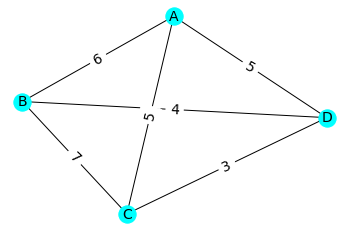

In [4]:
# 各都市と距離をグラフで描画

import networkx
import networkx as nx
import matplotlib.pyplot as plt

city_names = 'ABCD'

G = nx.Graph()

G.add_weighted_edges_from(
    [(city_names[i], city_names[j], d[i][j]) for i, j in itertools.combinations(list(range(N_CITY)), 2)]
)

pos = nx.spring_layout(G, k=0.5, seed=1)

nx.draw_networkx_labels(G, pos, font_size=14)

edge_labels = {(i, j): w['weight'] for i, j, w in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=14)

nx.draw(G, pos, node_color='cyan')

plt.axis('off')
plt.show()

決定変数$x_{u, v}$、ハミルトニアン$H_B(x) + AH_A(x)$を定義する。

In [5]:
# QUBOを表現する変数を用意
# 都市数^2の変数が必要
x = Array.create('x', shape=(N_CITY, N_CITY), vartype='BINARY')

# グラフのエッジの組み合わせ (重複なし) を取得
E = list(itertools.combinations(list(range(N_CITY)), 2))

# 第一項 (制約項) を定義
# H_A_1とH_A_2ではvとjの位置が入れ替わることに注意
H_A_1 = sum((1 - sum(x[v, j] for j in range(N_CITY))) ** 2 for v in range(N_CITY))
H_A_2 = sum((1 - sum(x[v, j] for v in range(N_CITY))) ** 2 for j in range(N_CITY))
H_A = Constraint(H_A_1 + H_A_2, label='HA')

# 第二項 (コスト、目的関数) を定義
# 参考文献[2]より、N + 1 = 1とする必要がある (n = 1, 2, ..., N)
# スタート地点に戻ることを表す
# プログラム上は添え字が0から始まるのでN + 1 = 0となる
H_B = sum((d[u][v] * sum(x[u, j] * x[v, j + 1] if j < N_CITY - 1 else x[u, j] * x[v, 0] for j in range(N_CITY))) for (u, v) in E)

# ハイパーパラメータを定義
A = 10

# ハミルトニアン全体を定義
Q = H_B + A * H_A

定義したハミルトニアンをQUBOに変換する。

In [6]:
# モデルをコンパイル
model = Q.compile()
qubo, offset = model.to_qubo()

OpenJijを用いて、SQA (Simulated quantum annealing) で解を求める。

In [7]:
# SQAを用いて問題を解く
sampler = oj.SQASampler()
# QUBOに先ほど.to_quboで作成したものを代入
num_reads = 1000
response = sampler.sample_qubo(Q=qubo, num_reads=num_reads)

各解を順番に見て、前の解より最小経路長が短い、または同じ解を取得する。

In [8]:
# numreads回分の解と、各解に対応するスピンのエネルギー、インデックスを取得
states = response.states
energies = response.energies
indices = response.indices

# 各解の中で最小経路長
# 初期値には十分大きな値を与える
min_path_length = 1000

# キー = 経路, 値 = 経路長の辞書
result = {}

for num_read in range(num_reads):
    # 解の辞書を生成
    dict_solution = {index: state for index, state in zip(indices, states[num_read])}

    # 得られた結果をデコード    
    decoded_sample = model.decode_sample(dict_solution, vartype='BINARY')

    # 破られている制約
    broken = decoded_sample.constraints(only_broken=True)
    # 制約が破られている場合は処理を行わない
    if broken:
        continue

    # 解を見やすくする処理
    x_solution = {}
    for i in range(N_CITY):
        x_solution[i] = {}
        for j in range(N_CITY):
            x_solution[i][j] = decoded_sample.array('x', (i, j))

    # 経路長を求める
    path_length = 0
    # 移動する順番を取得
    order = []
    for i in range(N_CITY):
        for j in range(N_CITY):
            if x_solution[i][j] == 1:
                order.append(j)
    # スタート地点を末尾に追加
    order.append(order[0])
    for i in range(N_CITY):
        path_length += d[order[i]][order[i + 1]]
    # 最小経路長を更新
    if min_path_length >= path_length:
        min_path_length = path_length
        path_str = ''.join([city_names[i] for i in order])
        result[path_str] = min_path_length

取得した解のリストから、最小経路長を求め、それ以外の経路長を持つ解を削除する。

最終的に残った解を最適解の候補とする。

In [9]:
# 結果の中から最小経路長を求める
min_value = min(result.values())
# 値が最小値のものを抽出 (最小経路長以外の結果を削除)
{k: v for k, v in result.items() if v == min_value}

{'ABDCA': 18,
 'BACDB': 18,
 'BDCAB': 18,
 'CABDC': 18,
 'CDBAC': 18,
 'DBACD': 18,
 'DCABD': 18}

例題のリンク元では、都市A→都市B→都市D→都市C→都市Aの順番で移動するのが最適解となり、その経路長は18とある。

最適解の候補を見ると、同等の解を求められている。また、同じ経路長を持つ経路は他にもあることが分かる。

## 5 Application 2: Flow Shop Scheduling Problem (FSP)

### 解説

FSP (フローショップ問題) は距離行列を事前に計算することで、TSPで定義した式を利用することができる。

仕事$i, j$の距離行列$d_{ij}$の求め方は複数あるが、論文では[26]の式を採用している。

[26]を用いた距離行列は以下のように表される。

<center>
$UBX^{k + 1}_{ij} = \max\{0, UBX^{k}_{ij} + (t_{jk} - t_{i, k + 1})\}$

$k = 1, 2, ..., m - 1$

$UBX^{1}_{ij} = 0$

$d_{ij} = UBX^{m}_{ij}$
</center>

ここで、$m$は作業 (機械) の数、$t_{jk}$は$i$番目の仕事における、$k$番目の作業 (機械$k$での処理) の処理時間を表す。

[26]から、$UBX^{h}_{uv}$は仕事$u$の終了から仕事$v$の開始までの機械$h$のアイドル時間の上限を表すことが分かる。

### 例題

[Numerical Optimizer SIMPLE例題集](https://www.msi.co.jp/nuopt/docs/v19/examples/html/02-25-02.html) における、フローショップ問題の例題を用いる。

ここで、各作業と処理時間は以下のように与えられる。

| |  作業1 (機械1)  |  作業2 (機械2)  | 作業3 (機械3) |
| :---: | :---: | :---: | :---: |
| 仕事a | 5時間 | 8時間 | 4時間 |
| 仕事b | 5時間 | 4時間 | 6時間 |
| 仕事c | 6時間 | 5時間 | 5時間 |


各作業の処理時間$t_{j, k}$を定義する。

In [10]:
# 仕事の数を定義
N_JOB = 3

# 機械の数を定義
N_MACHINE = 3

# 各作業の処理時間を定義
t = [
     [5, 8, 4],
     [5, 4, 6],
     [6, 5, 5]
]

# 仕事の名前
job_names = 'abc'

# 仕事の組み合わせを求める
E_machine = list(itertools.permutations(list(range(N_JOB)), 2))

# d_{ij} = N_JOB * N_JOBの行列を定義
d_job = [[0 for j in range(N_JOB)] for i in range(N_JOB)]

# 機械ごとにUBXを求める
for (i, j) in E_machine:
    # UBX^{m}_{ij}を計算
    UBX_ij = 0
    for k in range(1, N_MACHINE):
        UBX_ij = max(0, UBX_ij + (
            t[j][k - 1] - t[i][k]
        ))
    d_job[i][j] = UBX_ij

TSPと同様に決定変数、ハミルトニアンを定義する。

In [11]:
# QUBOを表現する変数を用意
# 都市数^2の変数が必要
x = Array.create('x', shape=(N_JOB, N_JOB), vartype='BINARY')

# 第一項 (制約項) を定義
# H_A_1とH_A_2ではvとjの位置が入れ替わることに注意
H_A_1 = sum((1 - sum(x[v, j] for j in range(N_JOB))) ** 2 for v in range(N_JOB))
H_A_2 = sum((1 - sum(x[v, j] for v in range(N_JOB))) ** 2 for j in range(N_JOB))
H_A = Constraint(H_A_1 + H_A_2, label='HA')

# 第二項 (コスト、目的関数) を定義
# 参考文献[2]より、N + 1 = 1とする必要がある (n = 1, 2, ..., N)
# スタート地点に戻ることを表す
# プログラム上は添え字が0から始まるのでN + 1 = 0となる
H_B = sum((d_job[u][v] * sum(x[u, j] * x[v, j + 1] if j < N_JOB - 1 else x[u, j] * x[v, 0] for j in range(N_JOB))) for (u, v) in E_machine)

# ハイパーパラメータを定義
A = 10

# ハミルトニアン全体を定義
Q = H_B + A * H_A

OpenJijを用いて、SQA (Simulated quantum annealing) で解を求める。

In [12]:
# SQAを用いて問題を解く
sampler = oj.SQASampler()
# QUBOに先ほど.to_quboで作成したものを代入
num_reads = 1000
response = sampler.sample_qubo(Q=qubo, num_reads=num_reads)

各解を順番に見て、前の解より最小経路長が短い、または同じ解を取得する。

In [13]:
# numreads回分の解と、各解に対応するスピンのエネルギー、インデックスを取得
states = response.states
energies = response.energies
indices = response.indices

# 各解の中で最小経路長
# 初期値には十分大きな値を与える
min_path_length = 1000

# キー = 経路, 値 = 経路長の辞書
result = {}

for num_read in range(num_reads):
    # 解の辞書を生成
    dict_solution = {index: state for index, state in zip(indices, states[num_read])}

    # 得られた結果をデコード    
    decoded_sample = model.decode_sample(dict_solution, vartype='BINARY')

    # 破られている制約
    broken = decoded_sample.constraints(only_broken=True)
    # 制約が破られている場合は処理を行わない
    if broken:
        continue

    # 解を見やすくする処理
    x_solution = {}
    for i in range(N_JOB):
        x_solution[i] = {}
        for j in range(N_JOB):
            x_solution[i][j] = decoded_sample.array('x', (i, j))

    # TODO: 1度も実行されない仕事がある現象への応急処置なので後で対処する
    is_continue = False
    for i in range(N_JOB):
        if sum(x_solution[i].values()) == 0:
            is_continue = True
            break
    if is_continue:
        continue

    # 経路長を求める
    path_length = 0
    # 移動する順番を取得
    order = []
    for i in range(N_JOB):
        for j in range(N_JOB):
            if x_solution[i][j] == 1:
                order.append(j)
    # スタート地点を末尾に追加
    order.append(order[0])
    for i in range(N_JOB):
        path_length += d_job[order[i]][order[i + 1]]
    # 最小経路長を更新
    if min_path_length >= path_length:
        min_path_length = path_length
        path_str = (''.join(map(str, [job_names[i] for i in order])))[:N_JOB]
        result[path_str] = min_path_length

取得した解のリストから、最小経路長を求め、それ以外の経路長を持つ解を削除する。

最終的に残った解を最適解の候補とする。

In [14]:
# 結果の中から最小経路長を求める
min_value = min(result.values())
# 値が最小値のものを抽出 (最小経路長以外の結果を削除)
min_result = {k: v for k, v in result.items() if v == min_value}
min_result

{'acb': 4, 'bac': 4, 'bca': 4, 'cab': 4, 'cba': 4}

In [15]:
for k in min_result:
    print('実行順: {}'.format(k))
    gantt = [[] for i in range(N_MACHINE)]
    for i in k:
        # 仕事の添え字を取得
        job_i = job_names.index(i)
        for m in range(N_MACHINE):
            # tから時間を取得してその分追加
            for mm in range(N_MACHINE):
                if m == mm:
                    gantt[mm] += [i for _ in range(t[job_i][m])]
                elif m < mm and len(gantt[m]) > len(gantt[mm]):
                    # 重なる分を追加
                    gantt[mm] += ['*' for _ in range(len(gantt[m]) - len(gantt[mm]))]
    # 各作業の完了時間から最大値を取得
    complete_time = max([len(item) for item in gantt])
    print('完了時刻: {}'.format(complete_time))
    for item in gantt:
        item += ['*' for _ in range(complete_time - len(item))]
        print(''.join(item))
    print('-' * 10)

実行順: cba
完了時刻: 28
ccccccbbbbbaaaaa************
******cccccbbbb*aaaaaaaa****
***********cccccbbbbbb**aaaa
----------
実行順: bac
完了時刻: 28
bbbbbaaaaacccccc************
*****bbbb*aaaaaaaaccccc*****
*********bbbbbb***aaaa*ccccc
----------
実行順: bca
完了時刻: 28
bbbbbccccccaaaaa************
*****bbbb**cccccaaaaaaaa****
*********bbbbbb*ccccc***aaaa
----------
実行順: acb
完了時刻: 29
aaaaaccccccbbbbb*************
*****aaaaaaaacccccbbbb*******
*************aaaa*cccccbbbbbb
----------
実行順: cab
完了時刻: 29
ccccccaaaaabbbbb*************
******cccccaaaaaaaabbbb******
***********ccccc***aaaabbbbbb
----------


例題のリンク元では、最後の作業3の開始時刻が最も遅い仕事はaの24であり、その作業時間は4時間である。すなわち、最後の作業の完了時刻は28となる。

最適解の候補を見ると、同等の解を求められている。ただし、TSPと異なり、距離行列が直接問題を表現していないため、ガントチャートに直すと完了時刻が最小とならない解を含む場合がある。